In [1]:
"The reaction coodinate is calculated with both the simulated trajectories and all the single cell data."

'The reaction coodinate is calculated with both the simulated trajectories and all the single cell data.'

In [2]:
import dynamo as dyn
import numpy as np
from scipy import stats,signal
# import scvelo as scv
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.neighbors import KernelDensity
import networkx as nx
import os
import glob
import anndata
from scipy.interpolate import CubicSpline,interp1d
from voronoi_finite_polygons_2d import voronoi_finite_polygons_2d
from scipy.spatial import Voronoi, voronoi_plot_2d
from tslearn.metrics import dtw_path

/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
 

In [3]:
"load data ans simulated trajectories in 3rd step"

'load data ans simulated trajectories in 3rd step'

In [ ]:
# data_name = "EG_ab_bin1"
# data_name = "DG_bin_ppt"
data_name = "zebrafish_dynamo_part"

if data_name == "EG_ab_bin1":
    basis = "umap"
    branch_name = "Beta"
    L = 10
elif data_name == "DG_bin_ppt":
    basis = "pca"
    branch_name = ""
    L = 10
elif data_name == "zebrafish_dynamo_part":
    basis = "umap"
    # branch_name = "Melanophore"
    # branch_name = "Xanthophore"
    branch_name = 'Schwann Cell'
    L = 6

save = "True"
nrc = 7
dim_n=10
fp_path=f'result/{data_name}_K_nei_10_K_2_L_{L}/'
save_path = "RC_path/"
adata=dyn.read(fp_path + f'{data_name}_fp.h5ad')
adata

/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'Cell_type_colors', 'PCs', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'hvg', 'log1p', 'neighbors', 'pca', 'pca_fit', 'pca_mean', 'pp', 'umap'
    obsm: 'X', 'X_pca', 'X_umap', 'velocity_pca'
    varm: 'PCs'
    layers: 'M_s', 'M_ss', 'M_u', 'M_us', 'M_uu', 'Ms', 'Mu', 'X_Ms', 'X_Mu', 'X_spliced', 'X_unspliced', 'spliced', 'unspli

/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


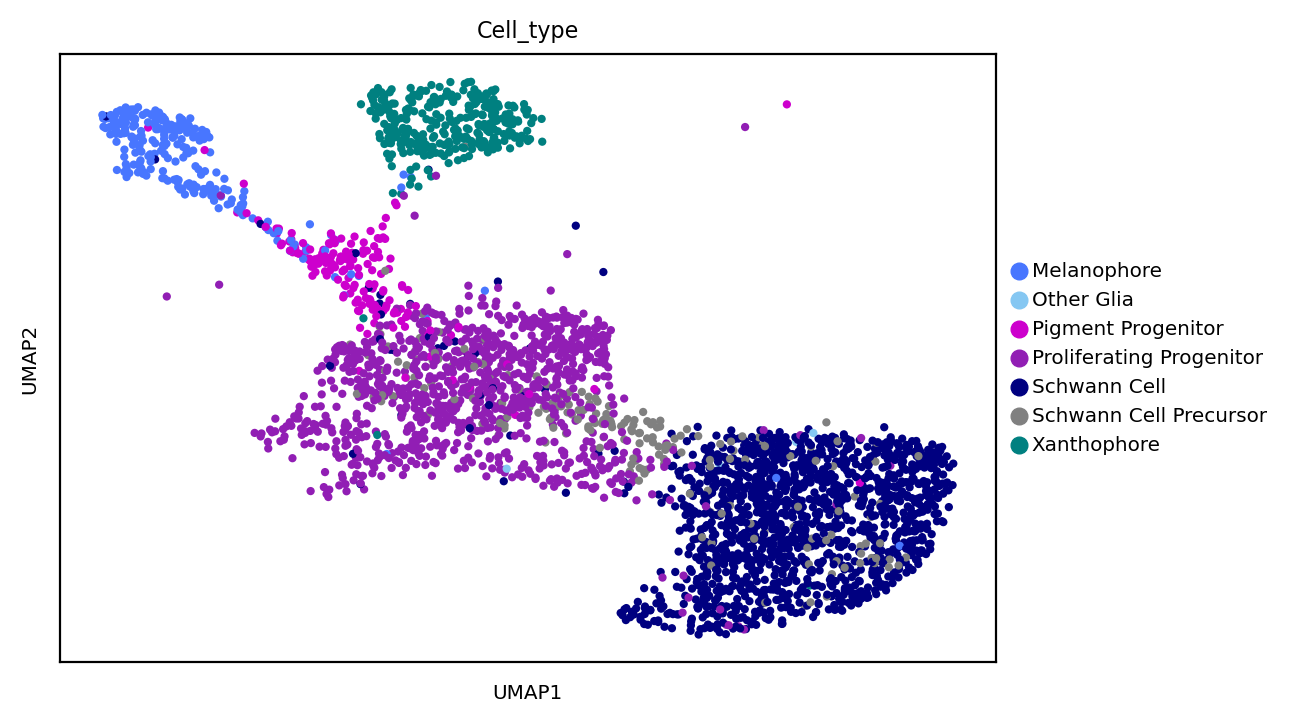

['Schwann Cell', 'Melanophore', 'Schwann Cell Precursor', 'Proliferating Progenitor', 'Xanthophore', 'Pigment Progenitor', 'Other Glia']
Categories (7, object): ['Melanophore', 'Other Glia', 'Pigment Progenitor', 'Proliferating Progenitor', 'Schwann Cell', 'Schwann Cell Precursor', 'Xanthophore']

In [5]:
import scanpy as sc
if data_name == "DG_bin_ppt":
    sc.pl.pca(adata, color = "Cell_type")
else:
    sc.pl.umap(adata, color = "Cell_type")
adata.obs["Cell_type"].unique()

In [6]:
result_path = fp_path +f"{branch_name}/"

P2M_traj_path= result_path + f"/{data_name}_P2M_traj/"
adata0_list=sorted(glob.glob(P2M_traj_path+'*h5ad')) 

In [7]:
len(adata0_list)

78

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import splprep,splev
from sklearn.cluster import DBSCAN
from scipy import interpolate
from numpy import linalg 
"""
Find path connecting data point
"""
class FindPath(object):
    def __init__(self, n = 20,traj_w=10,sf=1):  # __init__是python中的魔法方法,类初始化的时候会自动调用.
        self.n = n
        self.t = np.linspace(0,1,n)
        self.error = 1e100
        self.error_log=[]
        self.data_rc=[]
        self.tangent_v=[]
        self.w=traj_w
        self.sf=sf
        
    def fit(self, p1, p2,data):
        self.p1 = np.expand_dims(p1,axis=0) # (1, p1.shape)
        self.p2 = np.expand_dims(p2,axis=0)
        self.data = data
        self.cluster_labels=[]

        self.spline = p1 + np.multiply((p2 - p1) , np.expand_dims(self.t,axis=1))  # (10, p1.shape[1]) 把p1和p2之间的距离分成n段. spline是对应段节点的坐标

        print("把x_1和x_2之间的距离分成n段:")
        plt.plot(self.spline[:,0], self.spline[:,1], "ob:") # "o"为圆点, "b"为蓝色, ":"为点线
        plt.show()
        
        self.best_spline=self.spline.copy()
        
        update=True
        while update:
            update=self.__move()
#             if len(self.error_log)>=2:
#                 if abs(self.error_log[-1]-self.error_log[-2])/self.error_log[-1]<0.005:
#                     update=False
#                 else:
#                     update=True
#             else:
#                 update=True
            print("continue update? -->", update)


        return self.best_spline,self.data_rc
    
    def __move(self):  # python类中双下划线开头的函数名表示这个函数是类私有, 外面用object_name.__move()调用不了. 可以用 object_name._FindPath__move调用, 但不建议这么做.
        

        w=self.w
        traj_error_arr1,traj_sum1,pts_error_arr1,pts_sum1,density1,data_rc1=self.__error() 
        centers = self.spline.copy()
        
        updateIndexs = np.where(density1>0)[0]
        centers[updateIndexs,:]=(np.divide(pts_sum1[updateIndexs,:],np.expand_dims(density1[updateIndexs],axis=1))+\
                                w*traj_sum1[updateIndexs,:]/len(self.data))/(1+w)



        self.spline,tangent_v=self.__discretize(centers)
        
        dot_color=np.arange(self.spline.shape[0])
        cm=plt.cm.get_cmap('jet')
        plt.figure(figsize=(7.5,5))
        plt.scatter(self.spline[:,0],self.spline[:,1],c=dot_color,cmap=cm)
        plt.xlabel('X',fontsize=16)
        plt.ylabel('Y',fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()
        traj_error_arr2,traj_sum2,pts_error_arr2,pts_sum2,density2,data_rc2=self.__error() 

        error=w*np.sum(traj_error_arr2)+np.sum(pts_error_arr2)


        self.error_log.append(error)

        if error<self.error:
            self.error=error
            self.best_spline=self.spline.copy()
            self.data_rc=data_rc2
            self.tangent_v=tangent_v
            return True
        else:
            return False

        

    def __discretize(self,centers,sample_n=1,st_move=0.02):

        
        spline=centers.copy()
        centers[0,:]=self.p1#+st_move*(centers[0,:]-self.p1)#self.spline[0,:]+st_move*(centers[0,:]-self.spline[0,:])
        centers[-1,:]=self.p2#+st_move*(centers[-1,:]-self.p2)#self.spline[-1,:]+st_move*(centers[-1,:]-self.spline[-1,:])
        t = np.linspace(0,1, sample_n* self.n)

        center_list=[centers[:,i] for i in range(centers.shape[1])]
        tck, u = interpolate.splprep(center_list,s=self.sf,k=2)
        spline_list=splev(t,tck,ext=3)
        for k in range(len(spline_list)):
            spline[:,k]=spline_list[k][::sample_n]

        
        tangent_v=interpolate.splev(t,tck,der=1)
        
        return spline,tangent_v
        
    def __error(self):
        
        
        pts_error_arr=np.zeros(self.n)
        density = np.zeros(self.n)
        pts_sum=np.zeros_like(self.spline)
        
        traj_error_arr=np.zeros(self.n)
        traj_sum=np.zeros_like(self.spline)
        data_rc=[]
        for ind in range(len(self.data)):
            traj_t_span = self.data[ind].shape[0]
            spline_inds=[]
            spline_dist=[]
            for j in range(self.n):
                p=self.spline[j]
                
                dist=linalg.norm(self.data[ind]-p[None,:],axis=1)  # (data[ind].shape[0], ) data[ind]所有细胞和spline各个点的距离关系
                # print(dist.shape)
                traj_error_arr[j]+=np.amin(dist)
                traj_sum[j]+=self.data[ind][np.argmin(dist),:]
                

            traj_rc=np.zeros((self.data[ind].shape[0],))
            for i in range(traj_t_span):
                p = self.data[ind][i,:]
                dist = linalg.norm(self.spline - p[None,:], axis = 1) # data[ind]的每个细胞和spline所有点的距离关系
                pts_error_arr[np.argmin(dist)]+=np.amin(dist)
                pts_sum[np.argmin(dist)]+=self.data[ind][i,:]
                density[np.argmin(dist)]+=1
                traj_rc[i]=np.argmin(dist)
            data_rc.append(traj_rc)

        return traj_error_arr,traj_sum,pts_error_arr,pts_sum,density,data_rc

In [9]:
# sc.pl.umap(adata_traj, color = "Cell_type")

E_state_mean0: [4.625679  1.6769534]
M_state_mean0 [ 9.261319  -3.4762616]
把x_1和x_2之间的距离分成n段:


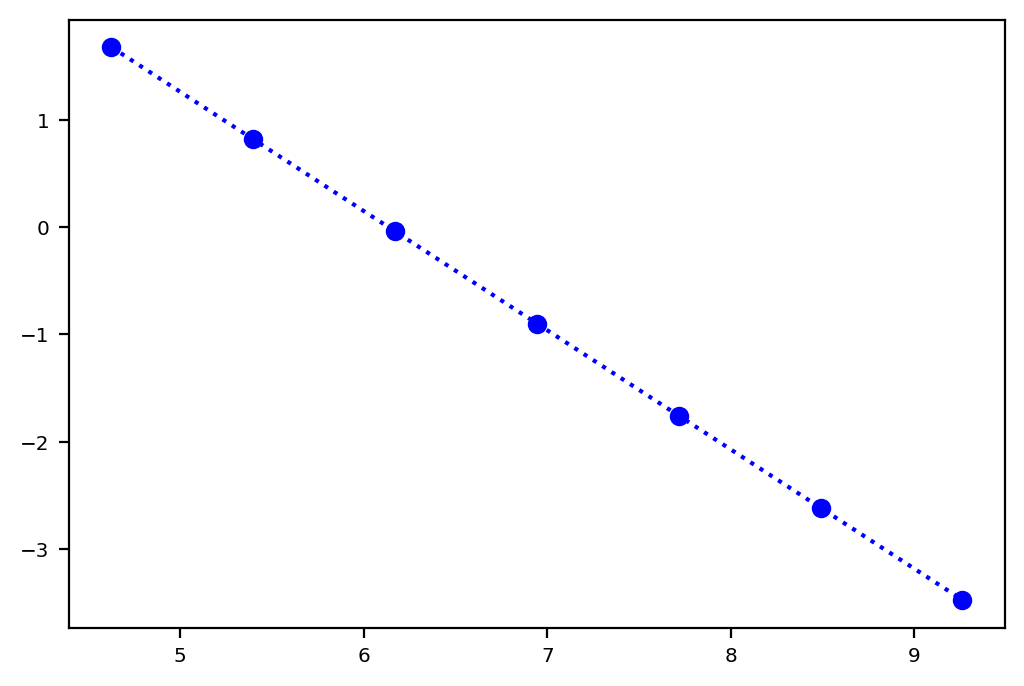

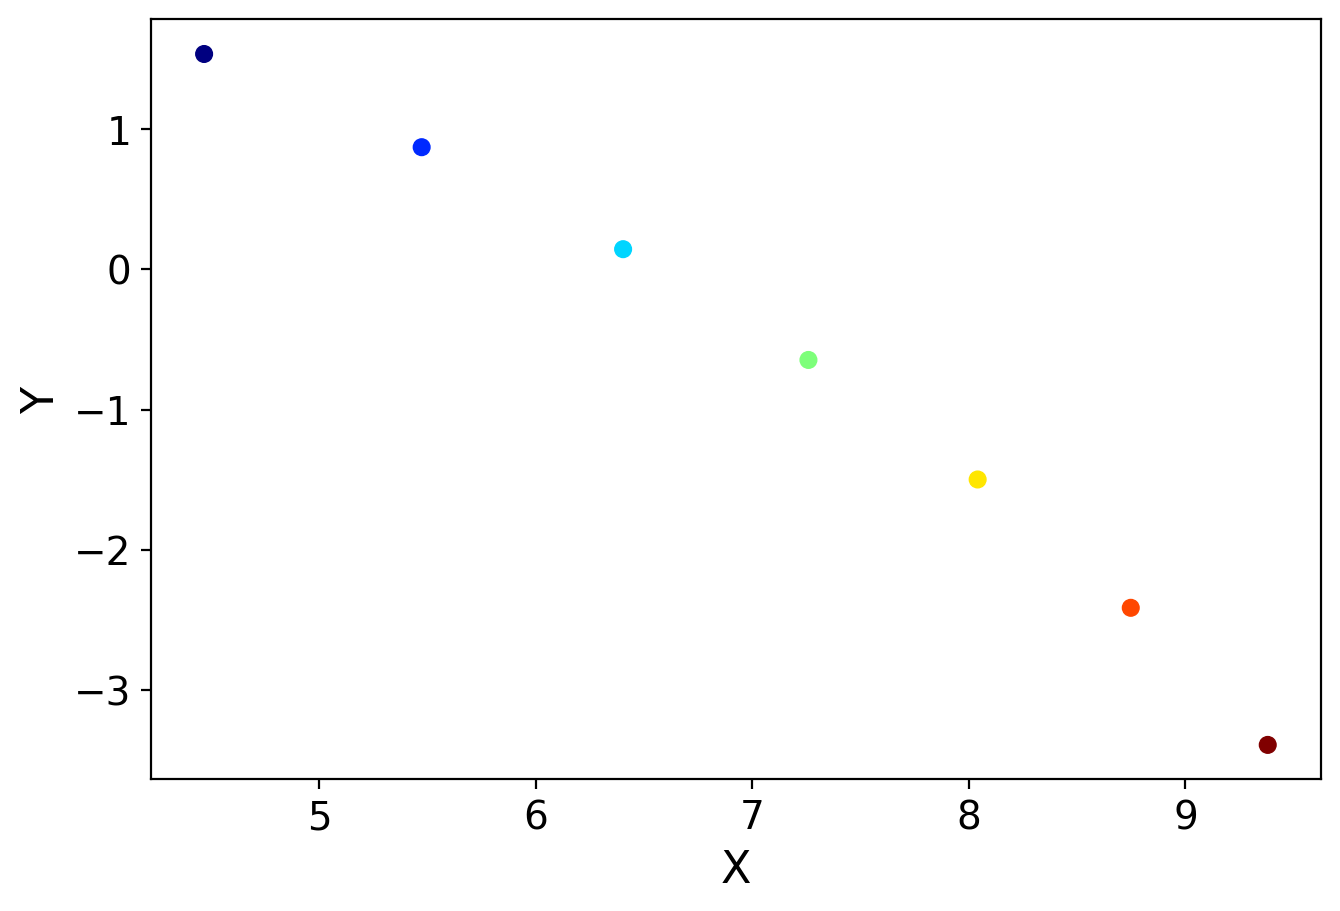

continue update? --> True


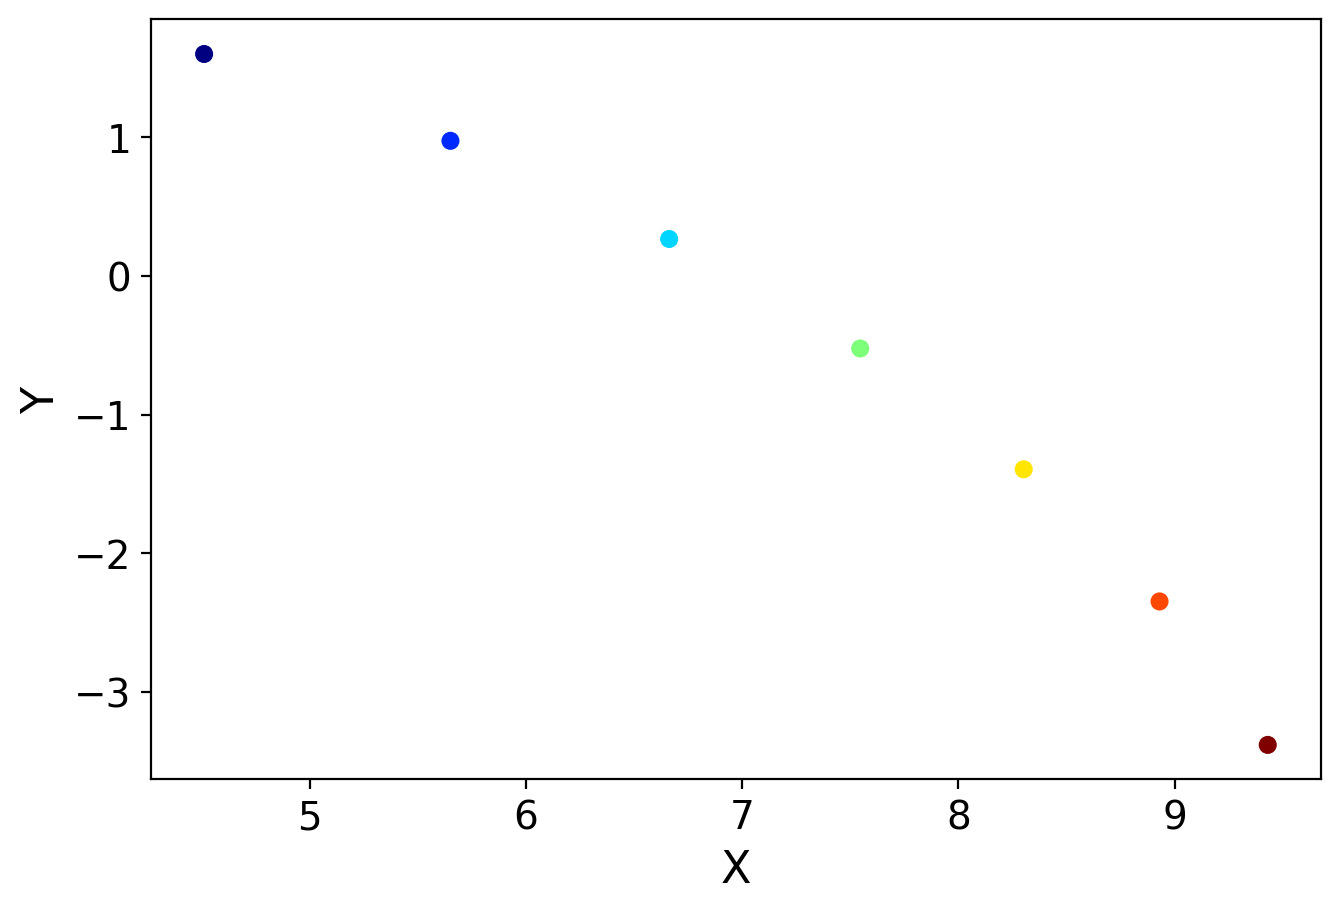

continue update? --> True


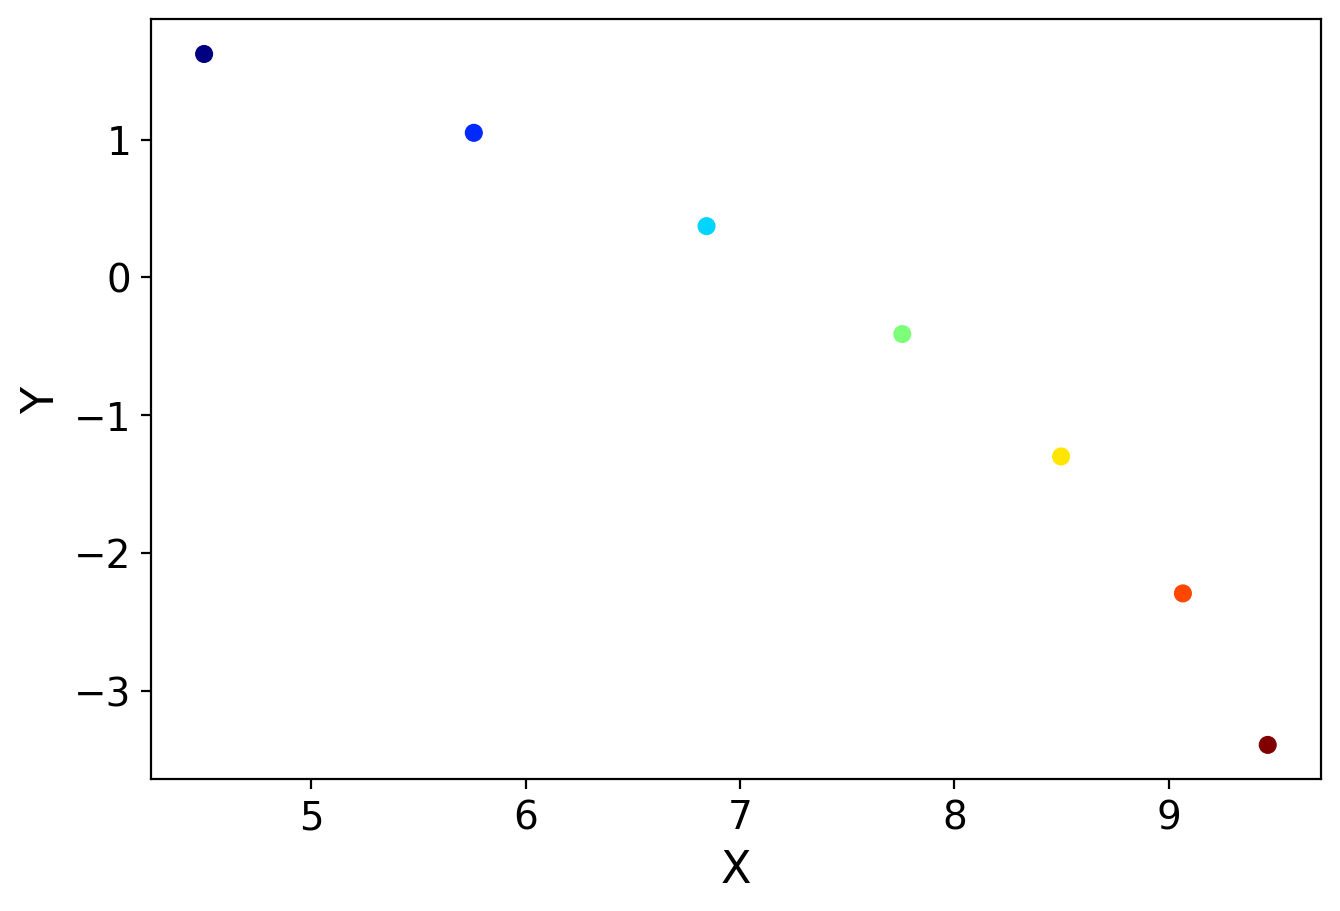

continue update? --> True


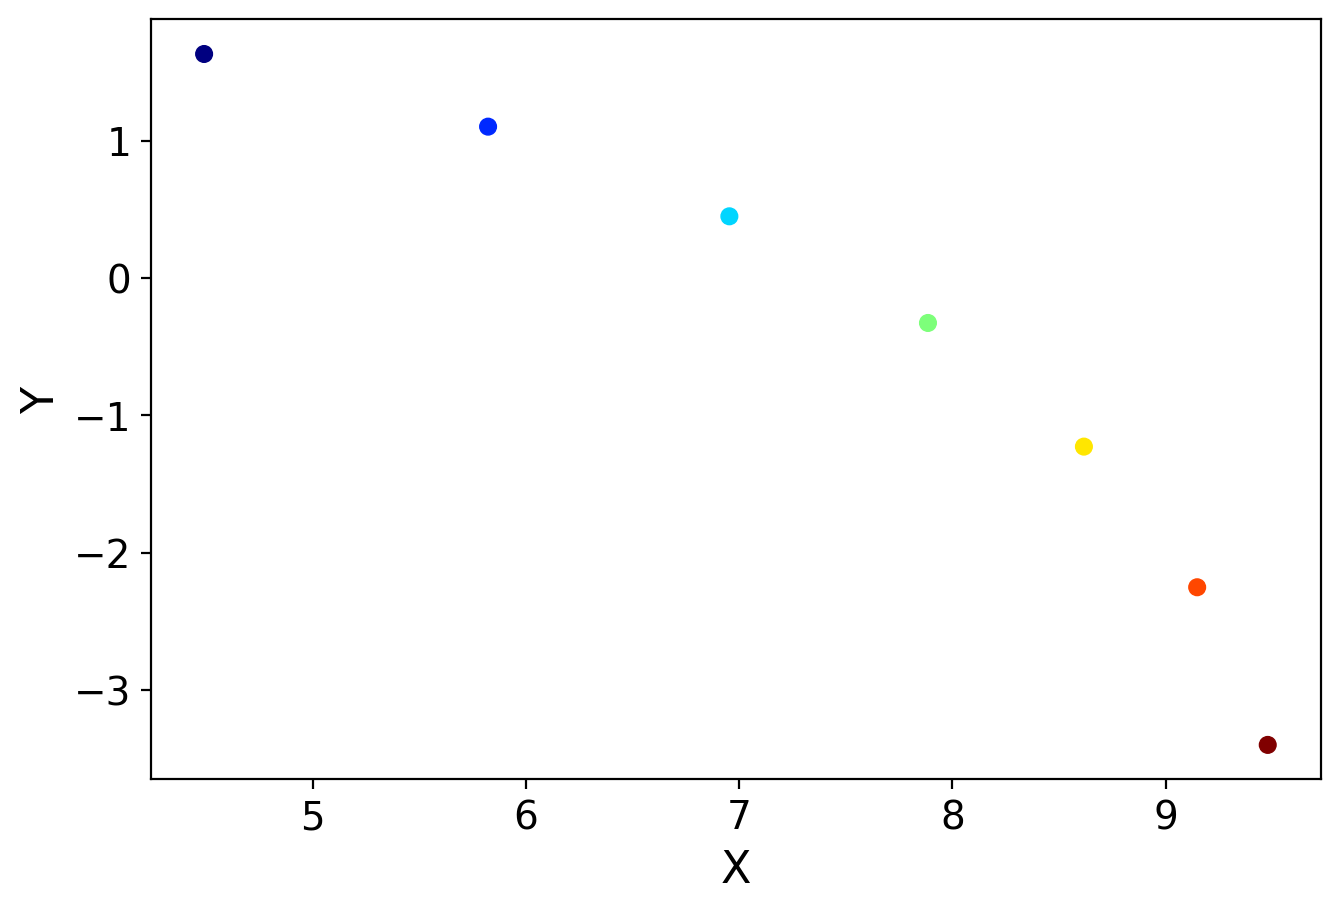

continue update? --> True


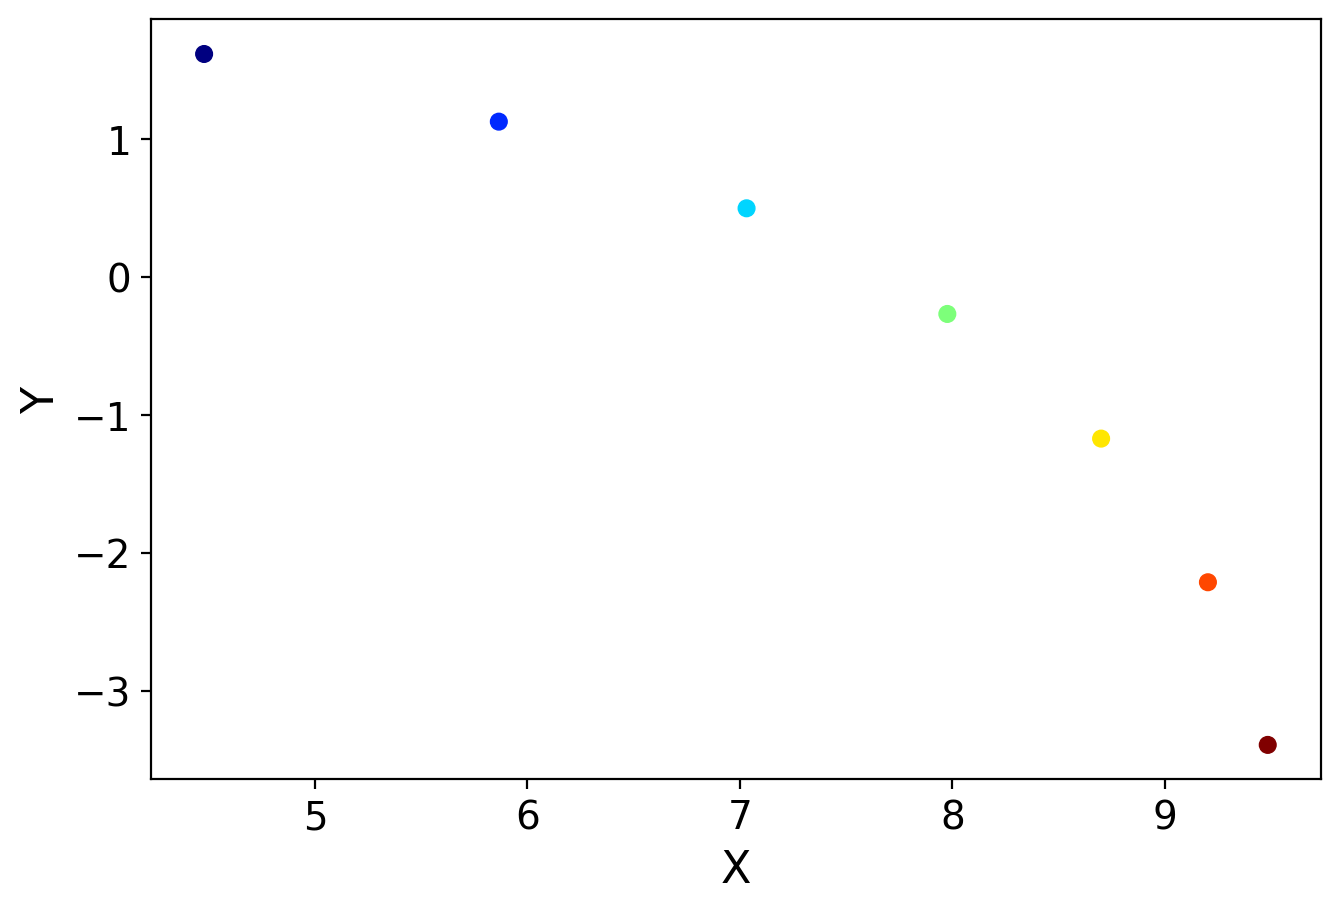

continue update? --> True


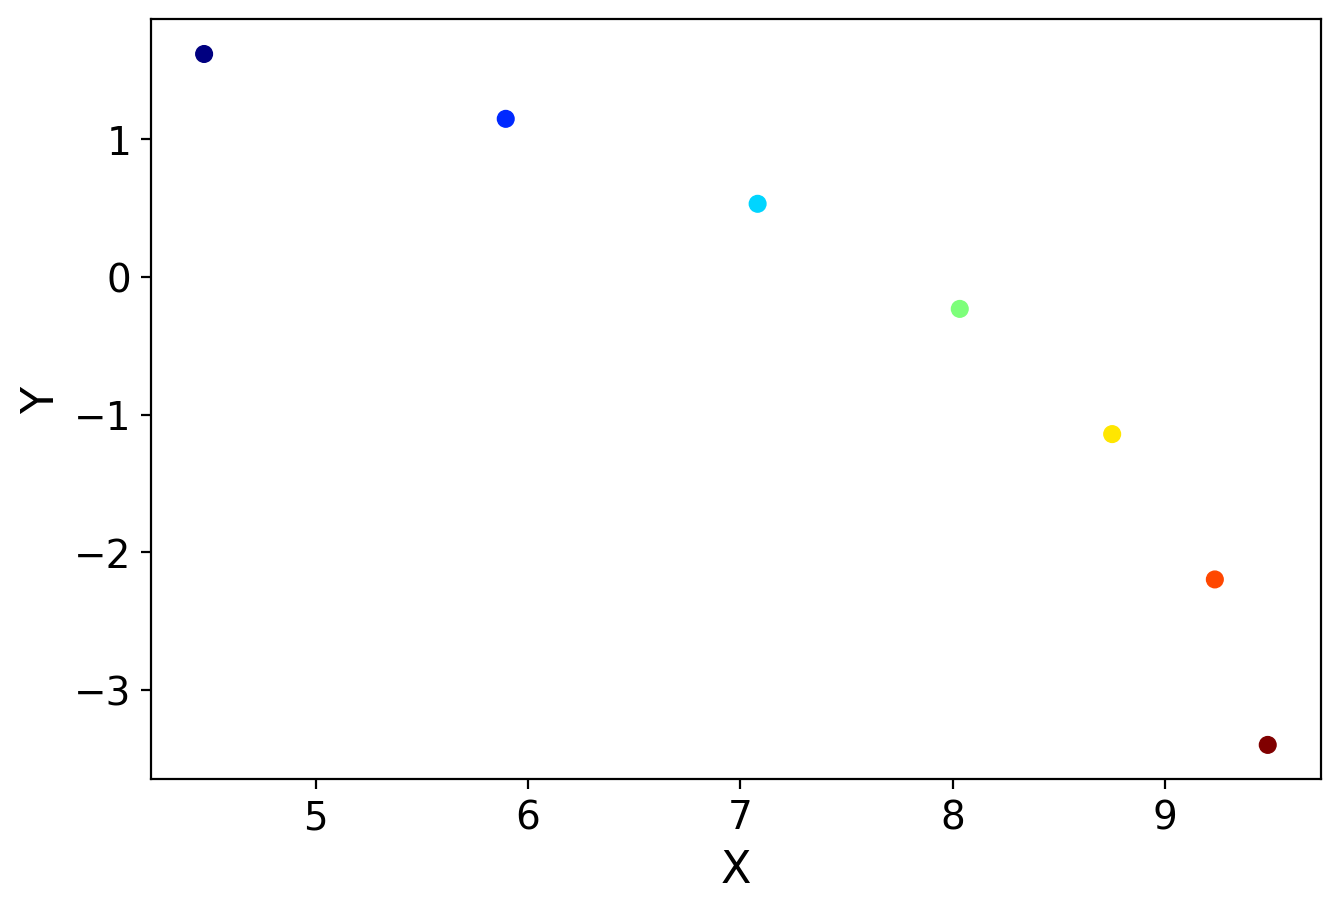

continue update? --> True


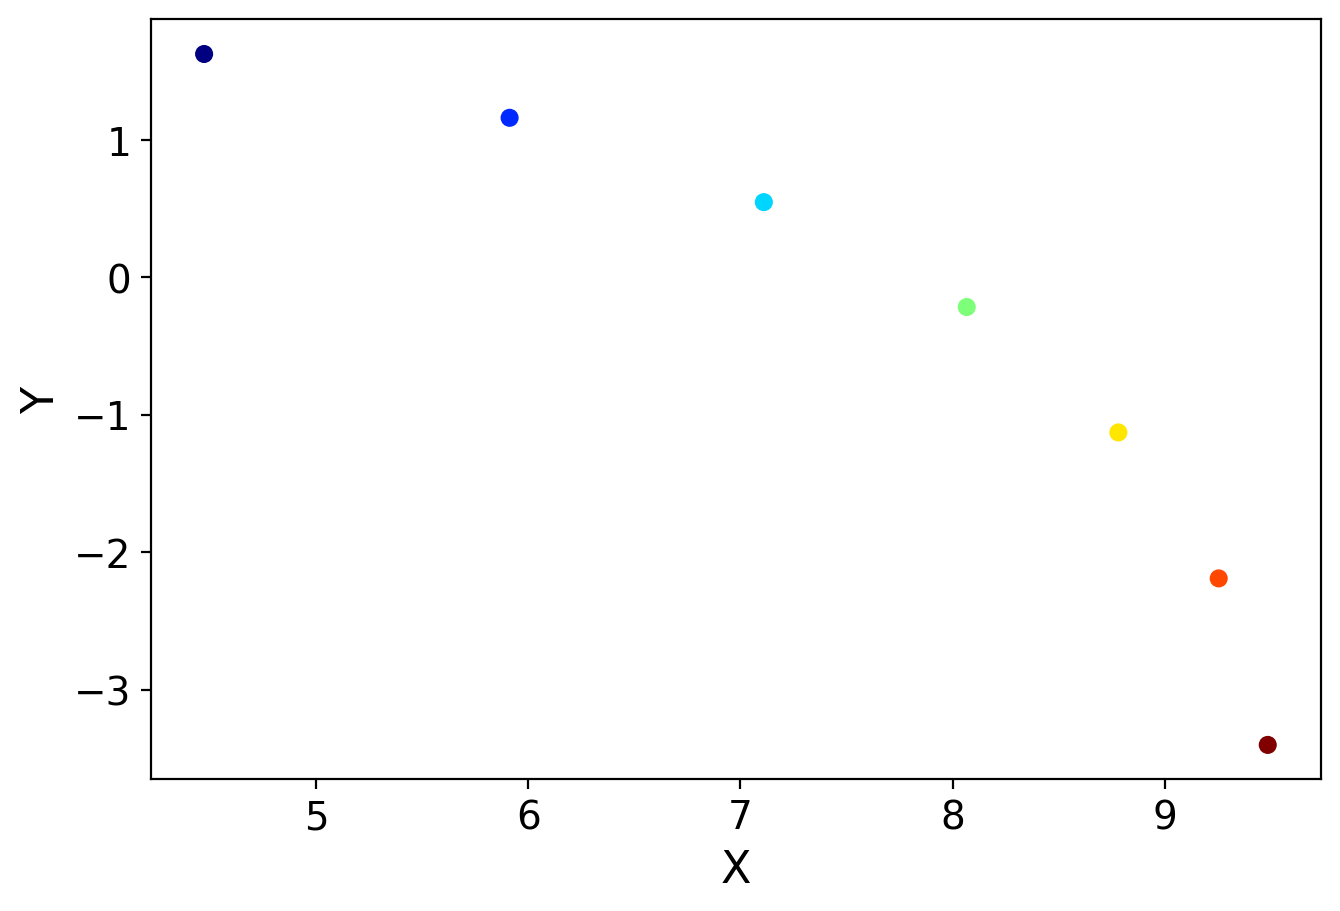

continue update? --> True


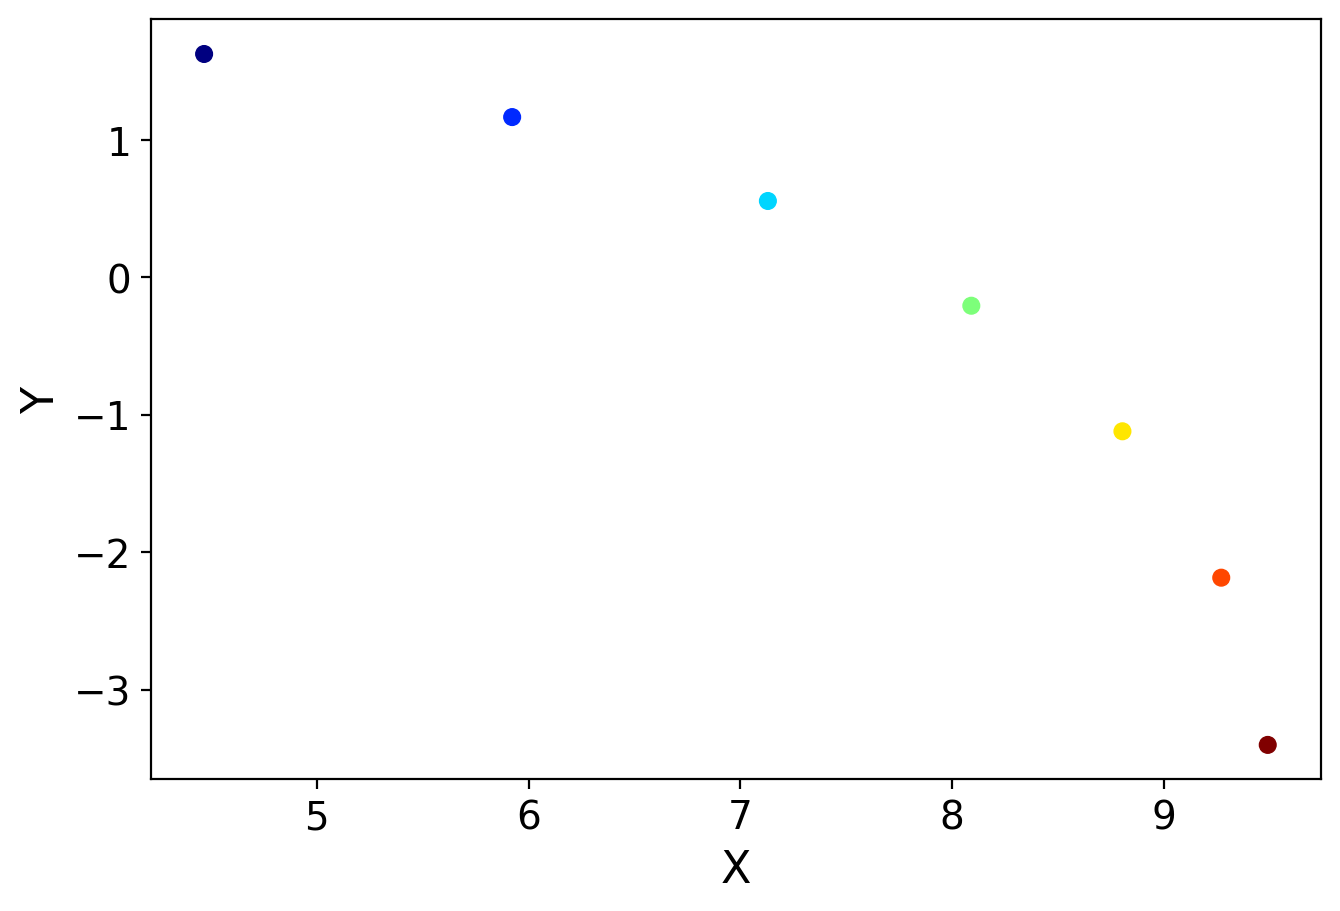

continue update? --> True


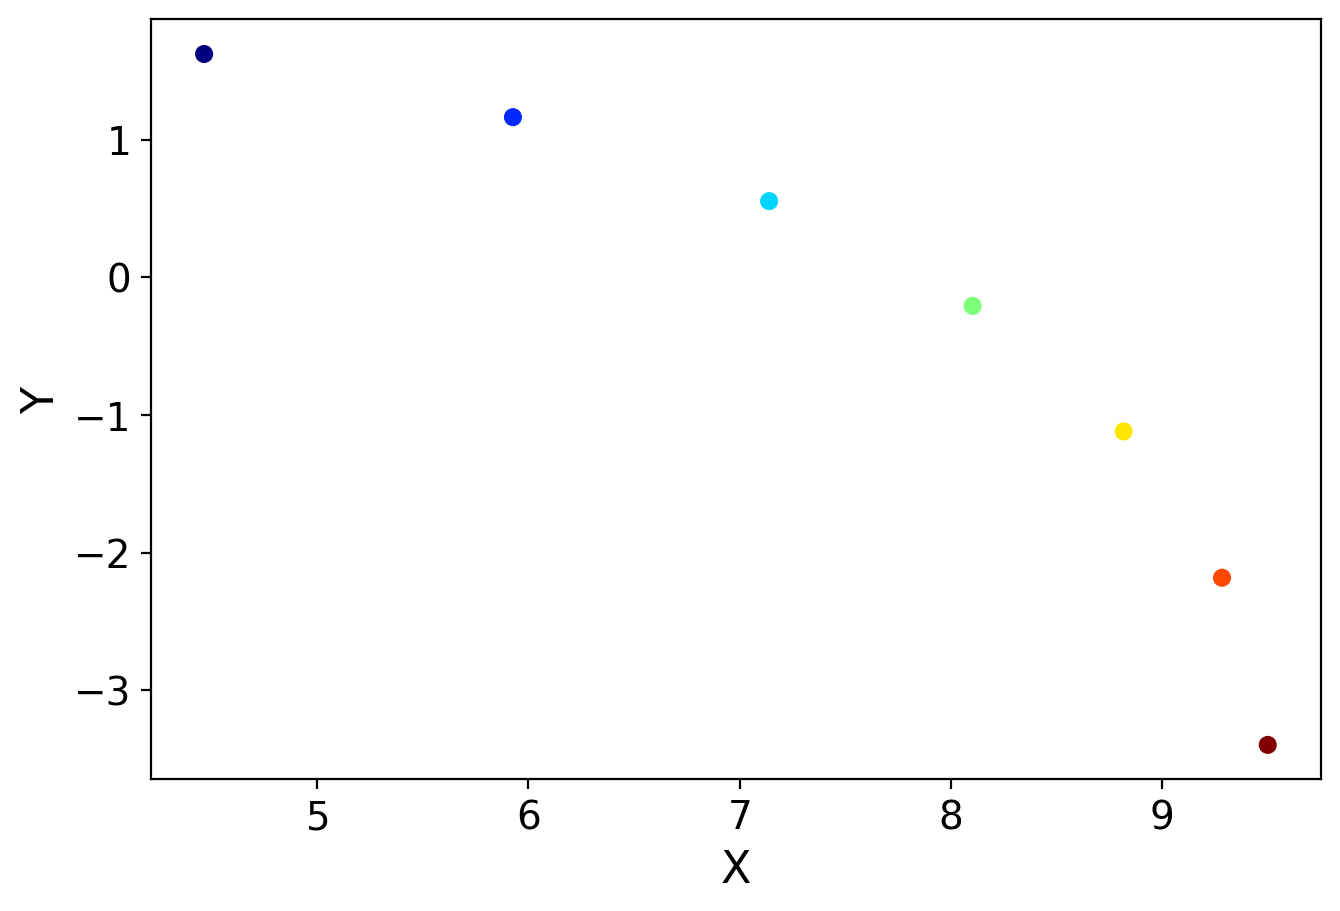

continue update? --> False
path0.shape: (7, 2)


In [10]:
traj_cl0=[]
adata_cl0=[]
E_state_cl0=[]
M_state_cl0=[]
for i in range(len(adata0_list)):
    adata_traj=anndata.read_h5ad(adata0_list[i])
    traj_arr=np.array(adata_traj.obsm[f'X_{basis}'])[:,:dim_n]  # NOTE:这里traj_arr原来用的是umap，现在我改成了pca。
    root_state=traj_arr[0,:]
    end_state=traj_arr[-1,:]
    
    traj_cl0.append(traj_arr)
    E_state_cl0.append(root_state)
    M_state_cl0.append(end_state)
    adata_cl0.append(adata_traj)

E_state_mean0=np.mean(np.array(E_state_cl0),axis=0)     # (2, )
M_state_mean0=np.mean(np.array(M_state_cl0),axis=0)     # (2, )

print("E_state_mean0:", E_state_mean0)
print("M_state_mean0", M_state_mean0)

X0=traj_cl0
x1=E_state_mean0
x2=M_state_mean0

FP=FindPath(nrc,traj_w=2,sf=0.5)  # nrc: num of reaction coordinates
path0,data_rc0=FP.fit(x1,x2,X0)  # 这里的path0是找出的{branch_name}支的反应坐标。
print("path0.shape:", path0.shape)
if save == "True":  
    if basis == "pca":
        np.save(save_path+f'{data_name}_{branch_name}_P2M_rc_nrc_{nrc}_dpca_{dim_n}.npy',path0)
    if basis == "umap":
        np.save(save_path+f'{data_name}_{branch_name}_P2M_rc_nrc_{nrc}.npy',path0)

In [11]:
if basis == "pca":
    path0 = np.load(save_path+f'{data_name}_{branch_name}_P2M_rc_nrc_{nrc}_dpca_{dim_n}.npy')
if basis == "umap":
    path0 = np.load(save_path+f'{data_name}_{branch_name}_P2M_rc_nrc_{nrc}.npy')

In [12]:
path0.shape

(7, 2)

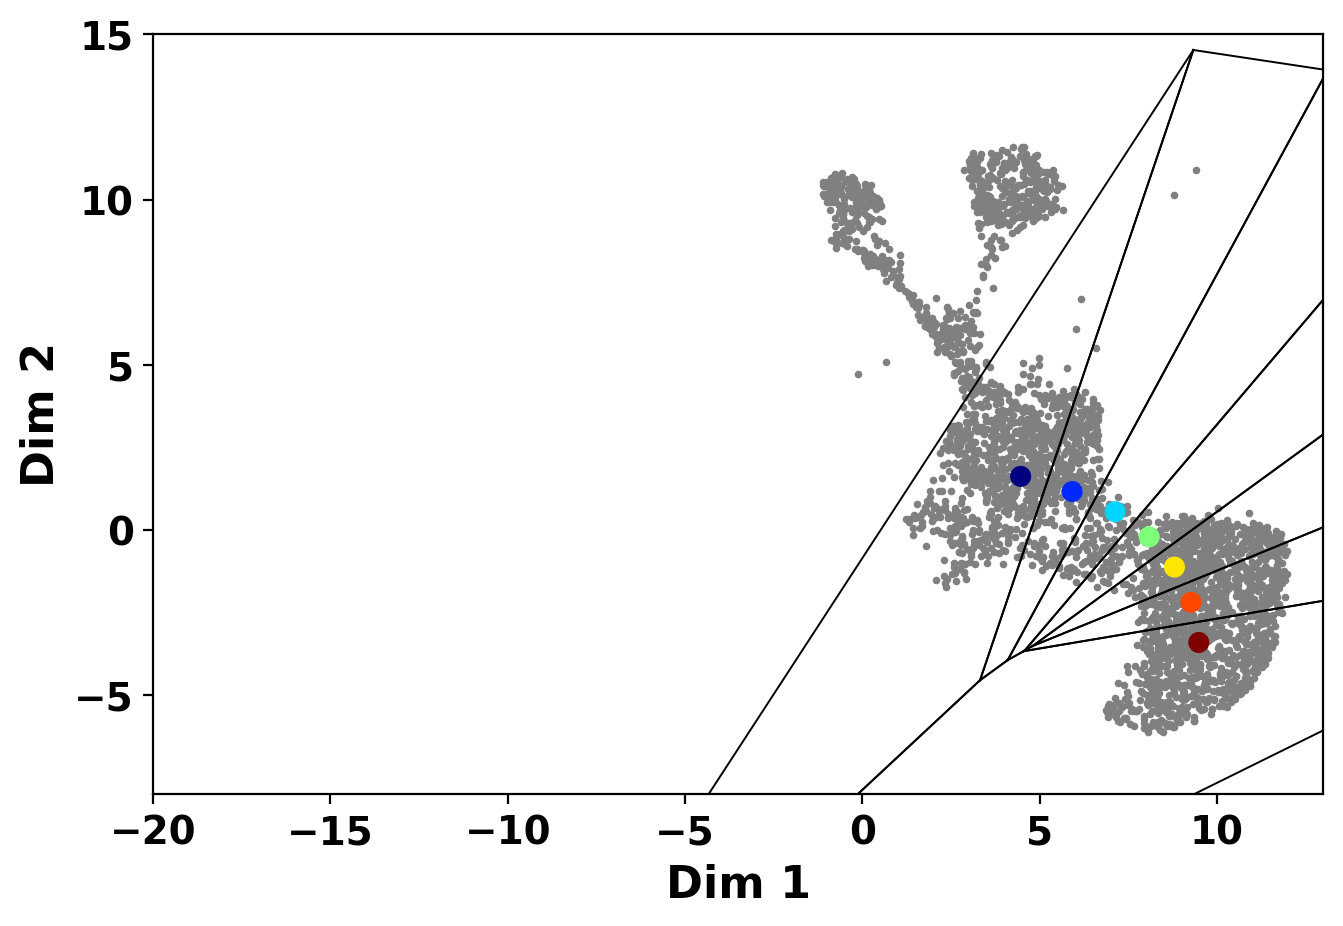

In [13]:
X0=traj_cl0


dot_color2=np.arange(path0.shape[0])
cm=plt.cm.get_cmap('jet')


fig,ax=plt.subplots(figsize=(7.5,5))


plt.scatter(adata.obsm[f'X_{basis}'][:,0],adata.obsm[f'X_{basis}'][:,1],s=5,color='grey')#,c=rho_w,cmap='viridis'


vor = Voronoi(path0[:,:2])

regions, vertices = voronoi_finite_polygons_2d(vor,radius=20)
for region in regions:
    polygon = vertices[region]
    for i in range(0,len(polygon)-1):
        plt.plot([polygon[i,0],polygon[i+1,0]], [polygon[i,1],polygon[i+1,1]], linewidth=0.7,color='k')
    plt.plot([polygon[-1,0],polygon[0,0]], [polygon[-1,1],polygon[0,1]],  linewidth=0.7,color='k')
    

# voronoi_plot_2d(vor,show_vertices=False,show_points=False)
plt.scatter(path0[:,0],path0[:,1],s=50,c=dot_color2,cmap=cm)

plt.xlabel('Dim 1',fontsize=16,fontweight='bold')
plt.ylabel('Dim 2',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.axis([-20,13,-8,15])

plt.savefig(result_path+ 'EG_vor.png',dpi=300)
plt.show()

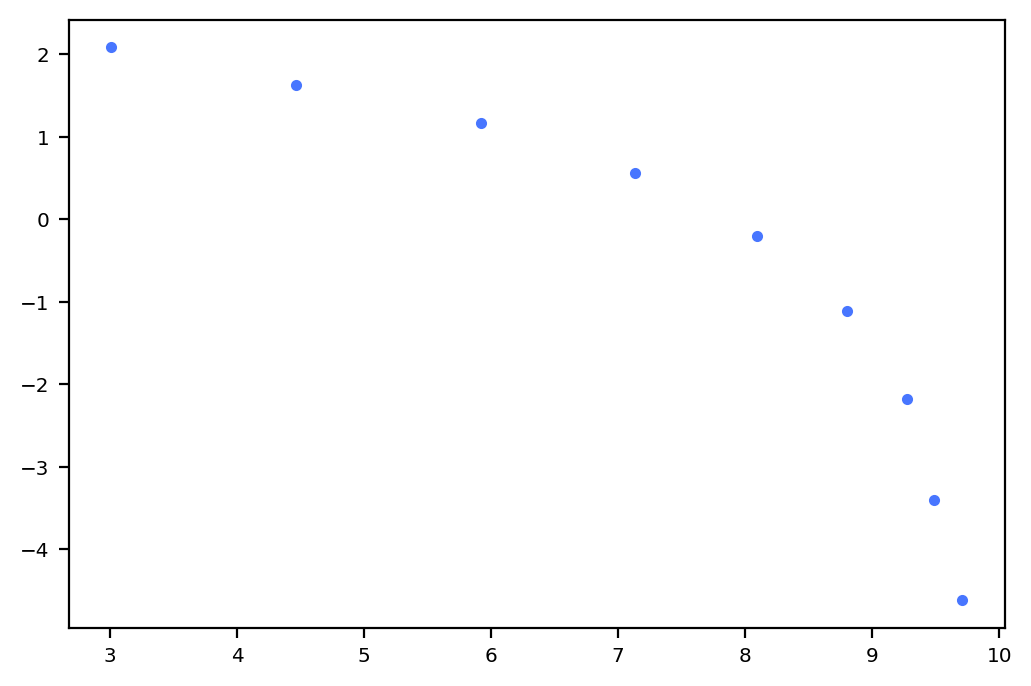

In [14]:
# extend_path0 是通过线性插值方法对原始路径 path0 进行前后扩展得到的新路径。

extend_range=1
x = np.arange(len(path0))
f = interp1d(x, path0,axis=0,fill_value='extrapolate')
xnew=np.arange(-extend_range,path0.shape[0]+extend_range)
extend_path0 = f(xnew)

plt.plot(extend_path0[:,0],extend_path0[:,1],'.')
plt.show()
if save == "True":
    if basis == "pca":
        np.save(save_path+f'{data_name}_{branch_name}_P2M_rc_extend_nrc_{nrc}_dpca_{dim_n}.npy',extend_path0 )
    if basis == "umap":
        np.save(save_path+f'{data_name}_{branch_name}_P2M_rc_extend_nrc_{nrc}.npy',extend_path0 )

In [15]:
# 可以通过下面这个例子理解上面的线性插值方法是怎么做的.
extend_range = 1

f = interp1d([0, 1, 2], [[1,2], [4,6], [7,3]], axis=0, fill_value='extrapolate')
xnew=np.arange(-extend_range,3)
extend_path0 = f(xnew)
print(extend_path0)

# 1 + (-1 - 0) × (4 - 1)/(1 - 0) = 1 + (-1) × 3 = -2
# 2 + (-1 - 0) × (6 - 2)/(1 - 0) = 2 + (-1) × 4 = -2

[[-2. -2.]
 [ 1.  2.]
 [ 4.  6.]
 [ 7.  3.]]


In [16]:
from scipy.spatial import Voronoi, distance

# --- 数据准备 ---
cells_2d = adata.obsm[f'X_{basis}'][:, :2]  # [N_cells, 2]
path_2d = path0[:, :2]                 # [N_rc_points, 2]

# --- 计算每个细胞属于哪个Voronoi格子（最近path点） ---
dist_matrix = distance.cdist(cells_2d, path_2d)  # [N_cells, N_rc_points]
closest_rc = np.argmin(dist_matrix, axis=1)      # 每个细胞对应的RC索引
closest_dist = np.min(dist_matrix, axis=1)       # 细胞到对应RC的距离

# --- 统计每个Voronoi cell包含哪些细胞 ---
cells_in_voronoi = {}
for rc_i in range(path_2d.shape[0]):
    idx_in_cell = np.where(closest_rc == rc_i)[0]
    cells_in_voronoi[rc_i] = idx_in_cell

# --- 找出每个Voronoi cell中距离该RC点最近的30个细胞 ---
nearest_30_cells = {}
for rc_i in range(path_2d.shape[0]):
    idx_in_cell = cells_in_voronoi[rc_i]
    if len(idx_in_cell) == 0:
        nearest_30_cells[rc_i] = np.array([])
        continue
    dist_to_rc = dist_matrix[idx_in_cell, rc_i]
    top_30_idx = idx_in_cell[np.argsort(dist_to_rc)[:10]]  # 取前30个最近的
    nearest_30_cells[rc_i] = top_30_idx


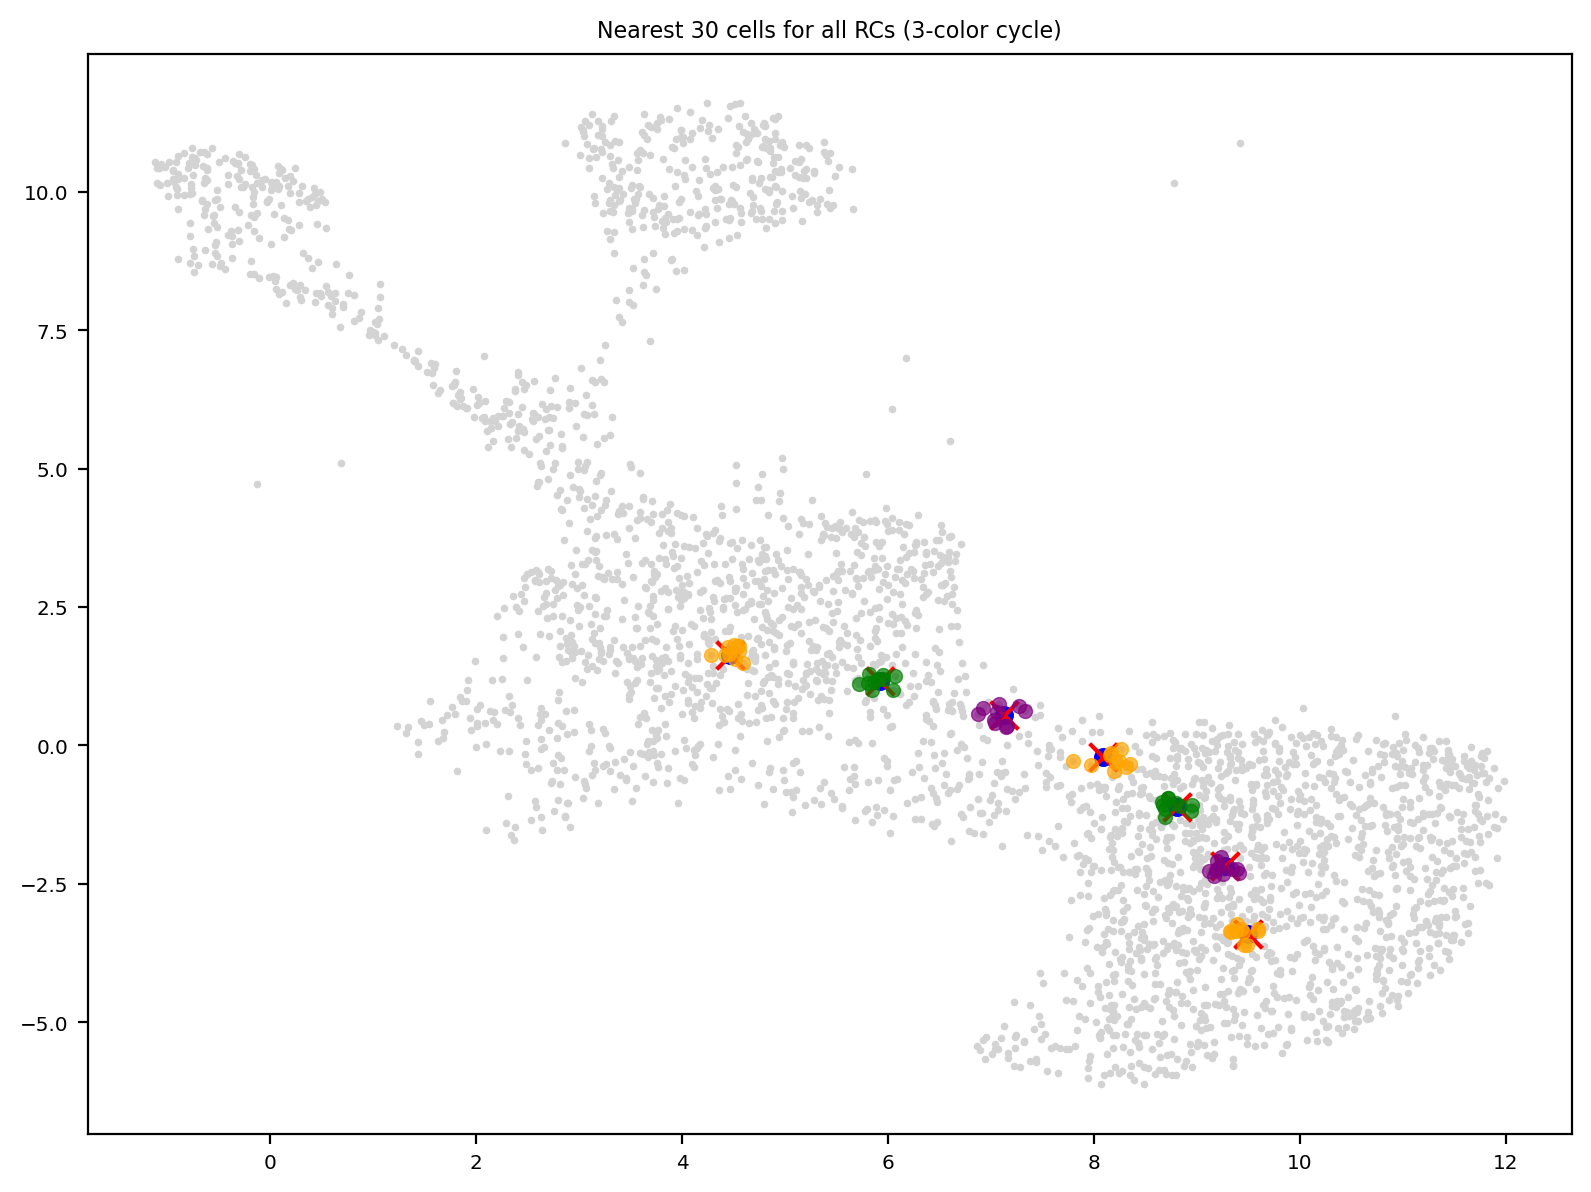

In [17]:
import matplotlib.pyplot as plt
import numpy as np

rc_num = path_2d.shape[0]

# 只取3种颜色，然后循环使用
base_colors = ['orange', 'green', 'purple']
plt.figure(figsize=(8,6))
plt.scatter(cells_2d[:,0], cells_2d[:,1], s=5, color='lightgrey', label='All cells')
plt.scatter(path_2d[:,0], path_2d[:,1], s=40, c='blue', label='Path points')

for rc_i in range(rc_num):
    color = base_colors[rc_i % 3]  # 每3种颜色循环
    plt.scatter(path_2d[rc_i,0], path_2d[rc_i,1], s=100, c='red', marker='x')
    plt.scatter(cells_2d[nearest_30_cells[rc_i],0],
                cells_2d[nearest_30_cells[rc_i],1],
                s=25, c=[color], alpha=0.7, label=f'RC {rc_i}')

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.title('Nearest 30 cells for all RCs (3-color cycle)')
plt.tight_layout()
plt.show()
